In [8]:
import torch
import matplotlib.pyplot as plt
import samplers
import torch.nn as nn
import torch.nn.functional as F
import util
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(0);

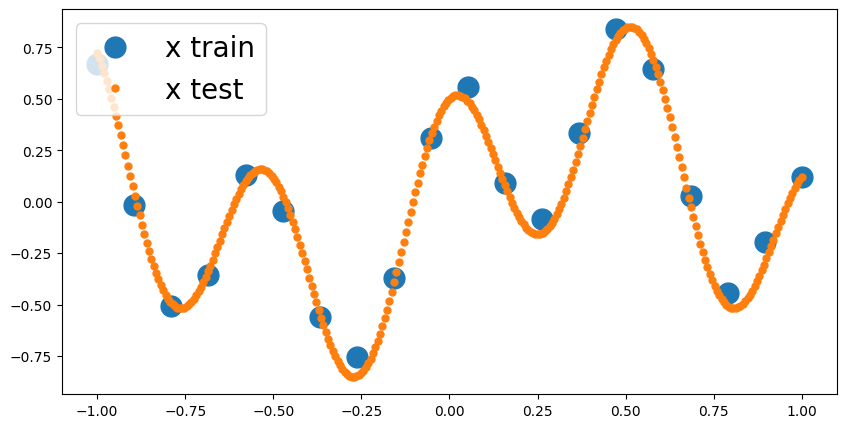

In [9]:
N_tr = 20
N_val = 300


x_val = torch.linspace(-1,1,N_val).view(-1,1)
y_val = (0.4*torch.sin(4*x_val) + 0.5*torch.cos(12*x_val)).view(-1,1)

x_train = torch.linspace(-1,1,N_tr).view(-1,1)
y_train = (0.4*torch.sin(4*x_train) + 0.5*torch.cos(12*x_train)) + torch.randn_like(x_train)*0.05

x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

plt.figure(figsize=(10,5))
plt.plot(x_train.numpy(),y_train.numpy(),'.',markersize=30, label='x train')
plt.plot(x_val.numpy(),y_val.numpy(),'.',markersize=10, label='x test')

plt.legend(fontsize=20)
plt.show()

In [10]:
width = 20
net = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1),
)

In [11]:
params_init = util.flatten(net).to(device).clone()
#define prior
tau_list = []
tau = 1.
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [12]:
step_size = 1e-3
num_samples = 1000#0
L = 20
tau_out = 1/(0.05)**2 #10.

In [13]:
params_hmc = samplers.sample_model(net, x_train, y_train, model_loss='regression',params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,normalizing_const=N_tr, tau_list=tau_list)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:11 | 0d:00:00:00 | #################### | 1000/1000 | 90.01       
Acceptance Rate 0.57


tensor(1.)
399.99999999999994

Expected validation log probability: -2045.62

Expected MSE: 0.01


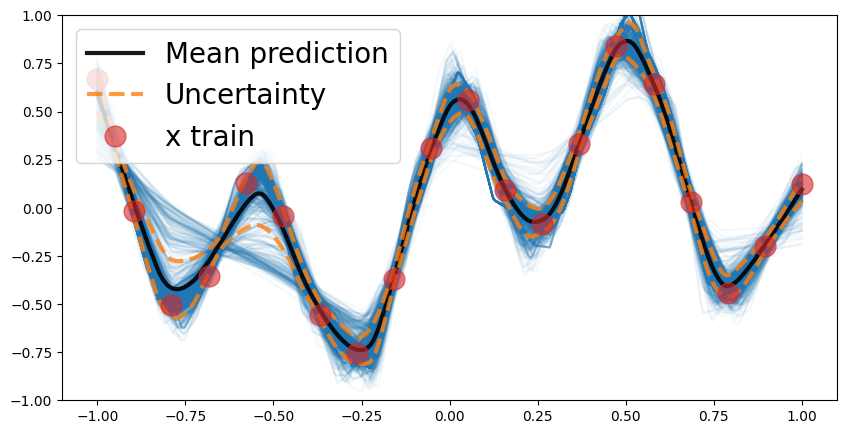

In [14]:
burn = 100
pred_list, log_prob_list = samplers.predict_model(net, x=x_val, y=y_val, model_loss='regression', samples=params_hmc[burn:], tau_out=tau_out, tau_list=tau_list)

print(tau_list[0])
print(tau_out)
print('\nExpected validation log probability: {:.2f}'.format(torch.stack(log_prob_list).mean()))
print('\nExpected MSE: {:.2f}'.format(((pred_list.mean(0) - y_val)**2).mean()))




plt.figure(figsize=(10,5))
plt.plot(x_val.cpu().numpy(),pred_list[:].cpu().numpy().squeeze().T, 'C0',alpha=0.051)
plt.plot(x_val.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T, 'k',alpha=0.9,linewidth=3,label= 'Mean prediction')
plt.plot(x_val.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T +pred_list.std(0).cpu().numpy().squeeze().T, '--C1',alpha=0.8,linewidth=3, label='Uncertainty')
plt.plot(x_val.cpu().numpy(),pred_list.mean(0).cpu().numpy().squeeze().T -pred_list.std(0).cpu().numpy().squeeze().T, '--C1',alpha=0.8,linewidth=3)

plt.plot(x_train.cpu().numpy(),y_train.cpu().numpy(),'.C3',markersize=30, label='x train',alpha=0.6)

plt.legend(fontsize=20)
plt.ylim([-1,1])
plt.show()